In [28]:
%matplotlib inline
import os
seed = 50
os.environ['PYTHONHASHSEED']=str(seed)
import scipy.io
import seaborn as sns
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from torch.optim.lr_scheduler import ExponentialLR
import numpy as np
from sklearn.model_selection import KFold
from tqdm import tqdm
import numpy as np
import pandas as pd
from IPython.display import clear_output, display
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import scipy.linalg
from sklearn.cross_decomposition import PLSRegression 
from sklearn.metrics import mean_squared_error as MSE
from matplotlib.ticker import MaxNLocator
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from datetime import timedelta
import warnings
warnings.simplefilter("ignore")
from tensorly.decomposition import robust_pca
from sklearn.cross_decomposition import CCA
from sklearn.linear_model import LinearRegression
# from tensorly.regression.cp_regression import CPRegressor
from tensorly.regression.tucker_regression import TuckerRegressor
from hopls import matricize, qsquared, HOPLS
# from skimage.metrics import normalized_root_mse
import random
# from qpfs import *
from Autoencoder import *
from utils import *
from hankelization import * 
random_seed = 5
random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
!CUBLAS_WORKSPACE_CONFIG=:16:8#:4096:8
device='cuda:0'
# device='cpu'

# Neurotycho food-tracking dataset, 32 channels

The monkey was tracking food rewards with the hand contralateral to the implant side. ECoG data and motion data were recorded simultaneously during the task (details in the reference). There was no eye tracking. ECoG and motion data were sampled at 1KHz and 120Hz, respectively, with time stamps synchronized. ECoG data consists of $32-$ time series (channels). The original signals are converted into a space time representation using a wavelet transform with Morlet wavelet. So, $X \in \mathbb{R}^{T \times 32 \times 27}$, where 27 - number of frequencies. $Y \in \mathbb{R}^{T \times 3}$ - coordinates of hand position.

<img src="pictures/2023-04-14_03-18-41.png" alt="Drawing" style="width: 300px;"/>

<img src="pictures/2023-04-14_03-19-11.png" alt="Drawing" style="width: 300px;"/>

In [31]:
X_test_full = np.transpose(scipy.io.loadmat('ECoG_X_test.mat')['X_hold_out'], (0,2,1))
Y_test_full = scipy.io.loadmat('ECoG_Y_test.mat')['Y_hold_out']
X_train_full = np.transpose(scipy.io.loadmat('ECoG_X_train.mat')['X_train'], (0,2,1))
Y_train_full = scipy.io.loadmat('ECoG_Y_train.mat')['Y_train']
print('X train:', X_train_full.shape)
print('Y train:', Y_train_full.shape)
print('X test:', X_test_full.shape)
print('Y test:', Y_test_full.shape)

X train: (12801, 27, 32)
Y train: (12801, 3)
X test: (6087, 27, 32)
Y test: (6087, 3)


In [32]:
X_train_arr_n = []
X_test_arr_n = []
Y_train_arr_n = []
Y_test_arr_n = []
for j in range(10):
    X_test = X_test_full[(j*50)+1500:(j*50)+2250]
    Y_test = Y_test_full[(j*50)+1500:(j*50)+2250]
    X_train = X_train_full[(j*100):(j*100)+1500]
    Y_train = Y_train_full[(j*100):(j*100)+1500]

    X_test = (X_test - X_test.mean()) / X_test.std() 
    Y_test = (Y_test - Y_test.mean()) / Y_test.std()
    X_train = (X_train - X_train.mean()) / X_train.std()
    Y_train = (Y_train - Y_train.mean()) / Y_train.std()
    X_test_arr_n.append(X_test)
    Y_test_arr_n.append(Y_test)
    X_train_arr_n.append(X_train)
    Y_train_arr_n.append(Y_train)
    
X_train_arr_t = []
X_test_arr_t = []
Y_train_arr_t = []
Y_test_arr_t = []
for j in range(10):
    X_test_arr_t.append(torch.from_numpy(X_test_arr_n[j]).float().to(device))
    Y_test_arr_t.append(torch.from_numpy(Y_test_arr_n[j]).float().to(device))
    X_train_arr_t.append(torch.from_numpy(X_train_arr_n[j]).float().to(device))                    
    Y_train_arr_t.append(torch.from_numpy(Y_train_arr_n[j]).float().to(device))                                       

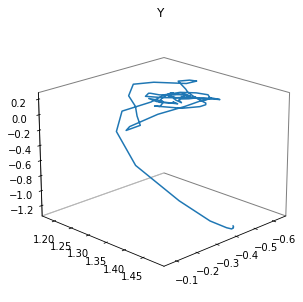

In [3]:
plot_y3D(Y_train_arr_n[0])

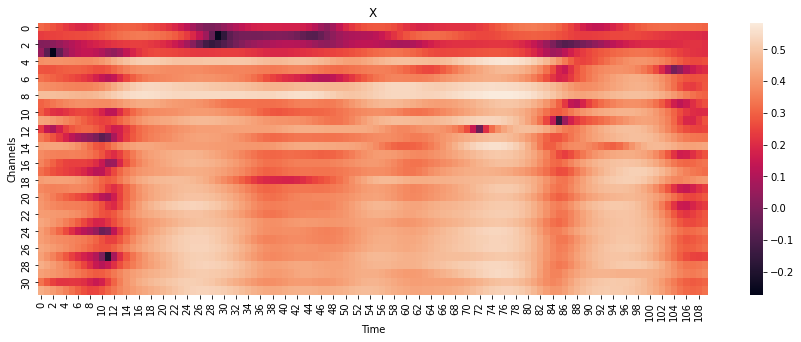

In [4]:
plot_x(X_train_arr_n[0])

## Without hankelization
### HOPLS

In [50]:
MSE_test = dict(np.load('experiments/ECoG32_wt_hopls.npz'))
print('Size of core tensor is', min(MSE_test, key=MSE_test.get), 'nRMSE =', np.round(MSE_test[min(MSE_test, key=MSE_test.get)],4))

Size of core tensor is Ln = (2,3), Km = 1, R = 29 nRMSE = 1.6989


100%|██████████| 30/30 [08:53<00:00, 17.79s/it]


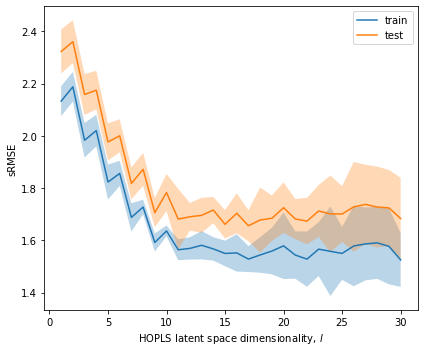

17 components with nRMSE = 1.655749361134878 +- 0.05031985241737451


In [51]:
rmse = []
for R in tqdm(range(1,31)):
    tr = []
    te = []
    for j in range(10):
        rmse_te, rmse_tr, _ = compute_rmse_hopls(X_train_arr_n[j],Y_train_arr_n[j],X_test_arr_n[j],Y_test_arr_n[j], [2,3], [1], R_max=R,train=True)
        tr.append(rmse_tr)
        te.append(rmse_te)
    rmse.append((R, tr, te))

x = [r[0] for r in rmse]
y1_mean = np.array([np.mean(r[1]) for r in rmse])
y2_mean = np.array([np.mean(r[2]) for r in rmse])
y1_std = np.array([np.std(r[1]) for r in rmse])
y2_std = np.array([np.std(r[2]) for r in rmse])
plt.figure(figsize=(6, 5))

plt.plot(x, y1_mean, label='train')
plt.fill_between(x, y1_mean - y1_std, y1_mean + y1_std, alpha=0.3)

plt.plot(x, y2_mean, label='test')
plt.fill_between(x, y2_mean - y2_std, y2_mean + y2_std, alpha=0.3)
plt.ylabel(r'sRMSE')
plt.xlabel(r'HOPLS latent space dimensionality, $l$')

plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

print(np.argmin(np.array(y2_mean))+1,'components with nRMSE =', min(y2_mean), '+-', min(y2_std))


### MPCA

In [ ]:
U_x = scipy.io.loadmat('MPCA/32_X.mat')['ans']
MSE_mpca = rmse_mpca(X_train_arr_n[0], Y_train_arr_n[0], X_test_arr_n[0], Y_test_arr_n[0], U_x)

In [4]:
print('Rank of weight tensor is', min(MSE_mpca, key=MSE_mpca.get), 'nRMSE =', MSE_mpca[min(MSE_mpca, key=MSE_mpca.get)])

Rank of weight tensor is (1, 2) nRMSE = 1.7642609425051774


In [52]:
U_x = scipy.io.loadmat('MPCA/32_X.mat')['ans']
print('X_shape after MPCA:', [U_x[i,0].shape[0] for i in range(U_x.shape[0])])

X_shape after MPCA: [1, 8]


In [53]:
RMSE_MPCA = []
for j in tqdm(range(10)):
    RMSE_MPCA.append(compute_rmse_mpca(X_train_arr_n[j],Y_train_arr_n[j],X_test_arr_n[j],Y_test_arr_n[j], [1,2], U_x))  
print(np.array(RMSE_MPCA).mean(), '+-',  np.array(RMSE_MPCA).std())

100%|██████████| 10/10 [00:25<00:00,  2.56s/it]

1.726703359619703 +- 0.04314085839527889


### Autoencoder

In [7]:
MSE_test = dict(np.load('experiments/ECoG32_wt.npz'))
print('The best size of core tensor is', min(MSE_test, key=MSE_test.get))

The best size of core tensor is 7,6


In [ ]:
lr = 0.01
batch_size = 512
loss_fn = my_loss(3)
epochs = 55
step_size = 100

RMSE_AE = []
for j in range(10):

    fr, ch, y_sh = X_test_arr_n[j].shape[1], X_test_arr_n[j].shape[2], Y_test_arr_n[j].shape[1]
    ks = [fr,32,16,8,7]
    model = AutoEncoder_tensor(3, [ks], [ch,6], y_sh, indexing=False).to(device)
    model = train(model, X_train_arr_t[j], Y_train_arr_t[j], X_test_arr_t[j], Y_test_arr_t[j], lr, step_size, batch_size, epochs, loss_fn, True);

    X_train_lower = model.encode(X_train_arr_t[j]).cpu().detach().numpy()
    X_test_lower = model.encode(X_test_arr_t[j]).cpu().detach().numpy()

    RMSE_dict = {}
    for rank1 in range(1,X_train_lower.shape[1]+1,2):   
        for rank2 in range(1,X_train_lower.shape[2]+1,2):
            try:
                RMSE_dict[f'{rank1},{rank2}'] = tensor_regression(X_train_lower, Y_train_arr_n[j], X_test_lower, Y_test_arr_n[j], [rank1,rank2])
            except:
                continue
    RMSE_AE.append( RMSE_dict[min(RMSE_dict, key=RMSE_dict.get)])

In [39]:
print(np.array(RMSE_AE).mean(), '+-',  np.array(RMSE_AE).std())

1.0328142401763263 +- 0.03111805222625248


In [37]:
fr, ch, y_sh = X_test_arr_n[j].shape[1], X_test_arr_n[j].shape[2], Y_test_arr_n[j].shape[1]
ks = [fr,32,16,8,7]
model = AutoEncoder_tensor(3, [ks], [ch,6], y_sh, indexing=False).to(device)
print('Number of parameters:', sum(p.numel() for p in model.parameters()))

Number of parameters: 9767


## With hankelization along time dim

In [14]:
X_tr_ht_arr_n = []
X_te_ht_arr_n = []
Y_tr_ht_arr_n = []
Y_te_ht_arr_n = []
H_t_arr = []
for j in tqdm(range(10)):
    data, H_t = tensorization(X_train_arr_n[j], Y_train_arr_n[j], X_test_arr_n[j], Y_test_arr_n[j], [[10],[10]], [[0],[0]])
    X_tr_ht_n, Y_tr_ht_n, X_te_ht_n, Y_te_ht_n = data
    X_tr_ht_arr_n.append(X_tr_ht_n)
    Y_tr_ht_arr_n.append(Y_tr_ht_n)
    X_te_ht_arr_n.append(X_te_ht_n)
    Y_te_ht_arr_n.append(Y_te_ht_n)
    H_t_arr.append(H_t)
    
X_tr_ht_arr_t = []
X_te_ht_arr_t = []
Y_tr_ht_arr_t = []
Y_te_ht_arr_t = []
for j in range(10):
    X_tr_ht_arr_t.append(torch.from_numpy(X_tr_ht_arr_n[j]).float().to(device))
    X_te_ht_arr_t.append(torch.from_numpy(X_te_ht_arr_n[j]).float().to(device))
    Y_tr_ht_arr_t.append(torch.from_numpy(Y_tr_ht_arr_n[j]).float().to(device))                    
    Y_te_ht_arr_t.append(torch.from_numpy(Y_te_ht_arr_n[j]).float().to(device))  

100%|██████████| 10/10 [01:17<00:00,  7.71s/it]


### HOPLS

In [54]:
MSE_test = dict(np.load('experiments/ECoG32_ht_hopls.npz'))
print('Size of core tensor is', min(MSE_test, key=MSE_test.get), 'nRMSE =', np.round(MSE_test[min(MSE_test, key=MSE_test.get)],4))

Size of core tensor is Ln = (3,1,1), Km = (1,1), R = 20 nRMSE = 1.1461


100%|██████████| 15/15 [18:56<00:00, 75.77s/it] 


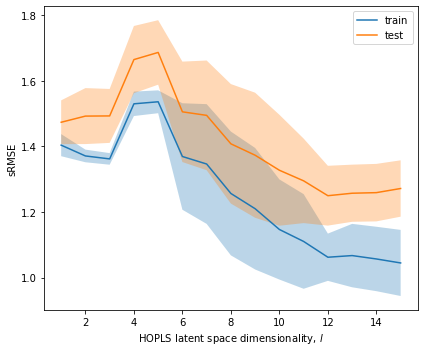

12 components with nRMSE = 1.2497309199675741 +- 0.06679712399536418


In [42]:
rmse = []
for R in tqdm(range(1,16)):
    tr = []
    te = []
    for j in range(10):
        rmse_te, rmse_tr, _ = compute_rmse_hopls(X_tr_ht_arr_n[j],Y_tr_ht_arr_n[j],X_te_ht_arr_n[j],Y_te_ht_arr_n[j], [3,1,1], [1,1], hankelization=[H_t_arr[j][-2],H_t_arr[j][-1]], R_max=R,train=True)
        tr.append(rmse_tr)
        te.append(rmse_te)
    rmse.append((R, tr, te))

x = [r[0] for r in rmse]
y1_mean = np.array([np.mean(r[1]) for r in rmse])
y2_mean = np.array([np.mean(r[2]) for r in rmse])
y1_std = np.array([np.std(r[1]) for r in rmse])
y2_std = np.array([np.std(r[2]) for r in rmse])
plt.figure(figsize=(6, 5))

plt.plot(x, y1_mean, label='train')
plt.fill_between(x, y1_mean - y1_std, y1_mean + y1_std, alpha=0.3)

plt.plot(x, y2_mean, label='test')
plt.fill_between(x, y2_mean - y2_std, y2_mean + y2_std, alpha=0.3)
plt.ylabel(r'sRMSE')
plt.xlabel(r'HOPLS latent space dimensionality, $l$')

plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

print(np.argmin(np.array(y2_mean))+1,'components with nRMSE =', min(y2_mean), '+-', min(y2_std))


### MPCA

In [55]:
U_x = scipy.io.loadmat('MPCA/32_X_ht.mat')['ans']
U_y = scipy.io.loadmat('MPCA/32_Y_ht.mat')['ans']
print('X',[U_x[i,0].shape[0] for i in range(U_x.shape[0])])
print('Y',[U_y[i,0].shape[0] for i in range(U_y.shape[0])])

X [10, 1, 8]
Y [8, 3]


In [13]:
MSE_test = dict(np.load('experiments/ECoG32_ht_ht_mpca.npz'))
print('Time. Size of core tensor is', min(MSE_test, key=MSE_test.get), 'nRMSE =', MSE_test[min(MSE_test, key=MSE_test.get)])

Time. Size of core tensor is (9, 1, 5) nRMSE = 1.982342863404438


In [56]:
RMSE_MPCA = []
for j in tqdm(range(10)):
    RMSE_MPCA.append(compute_rmse_mpca(X_tr_ht_arr_n[j],Y_tr_ht_arr_n[j],X_te_ht_arr_n[j],Y_te_ht_arr_n[j], [9,1,5], U_x, U_y, H_t_arr[j][-1]))  
print(np.array(RMSE_MPCA).mean(), '+-',  np.array(RMSE_MPCA).std())

100%|██████████| 10/10 [2:11:17<00:00, 787.71s/it] 

1.877859393125025 +- 0.06690909645414701


### Autoencoder

In [8]:
MSE_test = dict(np.load('experiments/ECoG32_ht.npz'))
print('The best size of core tensor is', min(MSE_test, key=MSE_test.get))

The best size of core tensor is 4,3,1


In [ ]:
lr = 0.01
batch_size = 512
loss_fn = my_loss(3)
epochs = 30
step_size = 100

RMSE_AE = []
for j in range(10):

    fr, ch, y_sh = X_test_arr_n[j].shape[1], X_test_arr_n[j].shape[2], Y_test_arr_n[j].shape[1]
    ks1 = [fr,32,16,8,3]
    ks2 = [ch,16,8,1]

    model = AutoEncoder_tensor(4, [ks1, ks2], [10,4], y_sh*10, indexing=True).to(device)
    model = train(model, X_tr_ht_arr_t[j],Y_tr_ht_arr_t[j],X_te_ht_arr_t[j],Y_te_ht_arr_t[j], lr, step_size, batch_size, epochs, loss_fn, True);

    X_train_lower = model.encode(X_tr_ht_arr_t[j]).cpu().detach().numpy()
    X_test_lower = model.encode(X_te_ht_arr_t[j]).cpu().detach().numpy()

    RMSE_dict = {}
    for rank1 in range(1,X_train_lower.shape[1]+1,1):   
        for rank2 in range(1,X_train_lower.shape[2]+1,1):
            for rank3 in range(1,X_train_lower.shape[3]+1,1):
                    RMSE_dict[f'{rank1},{rank2},{rank3}'] = tensor_regression(X_train_lower, Y_tr_ht_arr_n[j], X_test_lower, Y_te_ht_arr_n[j], [rank1,rank2,rank3], H_t_arr[j][-1])

    RMSE_AE.append( RMSE_dict[min(RMSE_dict, key=RMSE_dict.get)])

In [42]:
print(np.array(RMSE_AE).mean(), '+-',  np.array(RMSE_AE).std())

1.1460499363030996 +- 0.0501903971951346


In [34]:
fr, ch, y_sh = X_test_arr_n[j].shape[1], X_test_arr_n[j].shape[2], Y_test_arr_n[j].shape[1]
ks1 = [fr,32,16,8,3]
ks2 = [ch,16,8,1]

model = AutoEncoder_tensor(4, [ks1, ks2], [10,4], y_sh*10, indexing=True).to(device)
print('Number of parameters:', sum(p.numel() for p in model.parameters()))

Number of parameters: 6307


## With hankelization along space dim

In [18]:
X_tr_hs_arr_n = []
X_te_hs_arr_n = []
Y_tr_hs_arr_n = []
Y_te_hs_arr_n = []
for j in tqdm(range(10)):
    data, H_s = tensorization(X_train_arr_n[j], Y_train_arr_n[j], X_test_arr_n[j], Y_test_arr_n[j], [[2],[]], [[2],[]])
    X_tr_hs_n, Y_tr_hs_n, X_te_hs_n, Y_te_hs_n = data
    X_tr_hs_arr_n.append(X_tr_hs_n)
    Y_tr_hs_arr_n.append(Y_tr_hs_n)
    X_te_hs_arr_n.append(X_te_hs_n)
    Y_te_hs_arr_n.append(Y_te_hs_n)
    
X_tr_hs_arr_t = []
X_te_hs_arr_t = []
Y_tr_hs_arr_t = []
Y_te_hs_arr_t = []
for j in range(10):
    X_tr_hs_arr_t.append(torch.from_numpy(X_tr_hs_arr_n[j]).float().to(device))
    X_te_hs_arr_t.append(torch.from_numpy(X_te_hs_arr_n[j]).float().to(device))
    Y_tr_hs_arr_t.append(torch.from_numpy(Y_tr_hs_arr_n[j]).float().to(device))                    
    Y_te_hs_arr_t.append(torch.from_numpy(Y_te_hs_arr_n[j]).float().to(device))  

100%|██████████| 10/10 [00:00<00:00, 73.24it/s]


### HOPLS

In [9]:
MSE_test = dict(np.load('experiments/ECoG32_hs_hopls.npz'))
print('Size of core tensor is', min(MSE_test, key=MSE_test.get), 'nRMSE =', MSE_test[min(MSE_test, key=MSE_test.get)])

Size of core tensor is Ln = (2,2,1), Km = (1), R = 8 nRMSE = 1.2399357262375374


100%|██████████| 15/15 [03:06<00:00, 12.43s/it]


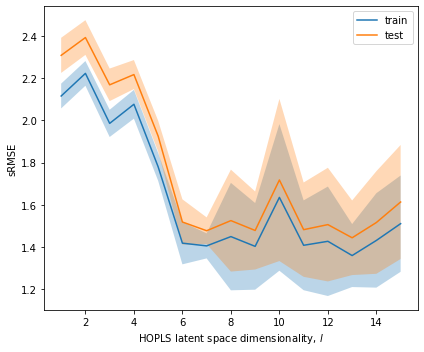

13 components with nRMSE = 1.443608532632106 +- 0.06328244302710274


In [44]:
rmse = []
for R in tqdm(range(1,16)):
    tr = []
    te = []
    for j in range(10):
        rmse_te, rmse_tr, _ = compute_rmse_hopls(X_tr_hs_arr_n[j],Y_tr_hs_arr_n[j],X_te_hs_arr_n[j],Y_te_hs_arr_n[j], [2,2,1], [1], R_max=R,train=True)
        tr.append(rmse_tr)
        te.append(rmse_te)
    rmse.append((R, tr, te))

x = [r[0] for r in rmse]
y1_mean = np.array([np.mean(r[1]) for r in rmse])
y2_mean = np.array([np.mean(r[2]) for r in rmse])
y1_std = np.array([np.std(r[1]) for r in rmse])
y2_std = np.array([np.std(r[2]) for r in rmse])
plt.figure(figsize=(6, 5))

plt.plot(x, y1_mean, label='train')
plt.fill_between(x, y1_mean - y1_std, y1_mean + y1_std, alpha=0.3)

plt.plot(x, y2_mean, label='test')
plt.fill_between(x, y2_mean - y2_std, y2_mean + y2_std, alpha=0.3)
plt.ylabel(r'sRMSE')
plt.xlabel(r'HOPLS latent space dimensionality, $l$')

plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

print(np.argmin(np.array(y2_mean))+1,'components with nRMSE =', min(y2_mean), '+-', min(y2_std))


### MPCA

In [57]:
U_x = scipy.io.loadmat('MPCA/32_X_hs.mat')['ans']
print([U_x[i,0].shape[0] for i in range(U_x.shape[0])])

[1, 7, 2]


In [10]:
MSE_test = dict(np.load('experiments/ECoG32_hs_hs_mpca.npz'))
print('Time. Size of core tensor is', min(MSE_test, key=MSE_test.get), 'nRMSE =', MSE_test[min(MSE_test, key=MSE_test.get)])

Time. Size of core tensor is (1, 5, 2) nRMSE = 1.767175335217373


In [58]:
RMSE_MPCA = []
for j in tqdm(range(10)):
    RMSE_MPCA.append(compute_rmse_mpca(X_tr_hs_arr_n[j],Y_tr_hs_arr_n[j],X_te_hs_arr_n[j],Y_te_hs_arr_n[j], [1,5,2], U_x))  
print(np.array(RMSE_MPCA).mean(), '+-',  np.array(RMSE_MPCA).std())

100%|██████████| 10/10 [00:51<00:00,  5.14s/it]

1.7371133060414565 +- 0.04238440389541333


### Autoencoder

In [9]:
MSE_test = dict(np.load('experiments/ECoG32_hs.npz'))
print('The best size of core tensor is', min(MSE_test, key=MSE_test.get))

The best size of core tensor is 5,5,1


In [ ]:
lr = 0.01
batch_size = 512
loss_fn = my_loss(3)
epochs = 65
step_size = 100
X_tr_hs_n, X_te_hs_n = X_tr_hs_n.transpose(0,2,1,3), X_te_hs_n.transpose(0,2,1,3)

RMSE_AE = []
for j in range(10):

    fr, ch, y_sh = X_test_arr_n[j].shape[1], X_test_arr_n[j].shape[2], Y_test_arr_n[j].shape[1]
    ks1 = [fr,32,16,8,5]

    model = AutoEncoder_tensor(4, [ks1, [2,3,1]], [ch-1,5], y_sh, indexing=True).to(device)
    model = train(model, X_tr_hs_arr_t[j].permute((0,2,1,3)),Y_tr_hs_arr_t[j],X_te_hs_arr_t[j].permute((0,2,1,3)),Y_te_hs_arr_t[j], lr, step_size, batch_size, epochs, loss_fn, True);

    X_train_lower = model.encode(X_tr_hs_arr_t[j].permute((0,2,1,3))).cpu().detach().numpy()
    X_test_lower = model.encode(X_te_hs_arr_t[j].permute((0,2,1,3))).cpu().detach().numpy()

    RMSE_dict = {}
    for rank1 in range(1,X_train_lower.shape[1]+1,1):   
        for rank2 in range(1,X_train_lower.shape[2]+1,1):
            for rank3 in range(1,X_train_lower.shape[3]+1,1):
                    RMSE_dict[f'{rank1},{rank2},{rank3}'] = tensor_regression(X_train_lower, Y_tr_hs_arr_n[j], X_test_lower, Y_te_hs_arr_n[j], [rank1,rank2,rank3])

    RMSE_AE.append( RMSE_dict[min(RMSE_dict, key=RMSE_dict.get)])

In [44]:
print(np.array(RMSE_AE).mean(), '+-',  np.array(RMSE_AE).std()) #65

1.0147997042036152 +- 0.023551257761004814


In [35]:
fr, ch, y_sh = X_test_arr_n[j].shape[1], X_test_arr_n[j].shape[2], Y_test_arr_n[j].shape[1]
ks1 = [fr,32,16,8,5]

model = AutoEncoder_tensor(4, [ks1, [2,3,1]], [ch-1,5], y_sh, indexing=True).to(device)
print('Number of parameters:', sum(p.numel() for p in model.parameters()))

Number of parameters: 9115


## With hankelization along both dim

In [22]:
X_tr_hb_arr_n = []
X_te_hb_arr_n = []
Y_tr_hb_arr_n = []
Y_te_hb_arr_n = []
H_b_arr = []
for j in tqdm(range(10)):
    data, H_b = tensorization(X_train_arr_n[j], Y_train_arr_n[j], X_test_arr_n[j], Y_test_arr_n[j], [[10,2],[10]], [[0,2],[0]])
    X_tr_hb_n, Y_tr_hb_n, X_te_hb_n, Y_te_hb_n = data
    X_tr_hb_arr_n.append(X_tr_hb_n)
    Y_tr_hb_arr_n.append(Y_tr_hb_n)
    X_te_hb_arr_n.append(X_te_hb_n)
    Y_te_hb_arr_n.append(Y_te_hb_n)
    H_b_arr.append(H_b)
    
X_tr_hb_arr_t = []
X_te_hb_arr_t = []
Y_tr_hb_arr_t = []
Y_te_hb_arr_t = []
for j in range(10):
    X_tr_hb_arr_t.append(torch.from_numpy(X_tr_hb_arr_n[j]).float().to(device))
    X_te_hb_arr_t.append(torch.from_numpy(X_te_hb_arr_n[j]).float().to(device))
    Y_tr_hb_arr_t.append(torch.from_numpy(Y_tr_hb_arr_n[j]).float().to(device))                    
    Y_te_hb_arr_t.append(torch.from_numpy(Y_te_hb_arr_n[j]).float().to(device))  

100%|██████████| 10/10 [01:18<00:00,  7.89s/it]


### HOPLS

In [45]:
MSE_test = dict(np.load('experiments/ECoG32_hb_hopls.npz'))
print('Size of core tensor is', min(MSE_test, key=MSE_test.get), 'nRMSE =', MSE_test[min(MSE_test, key=MSE_test.get)])

Size of core tensor is Ln = (2,3,3,1), Km = (3,1), R = 20 nRMSE = 1.1403114292767995


100%|██████████| 15/15 [49:34<00:00, 198.28s/it]


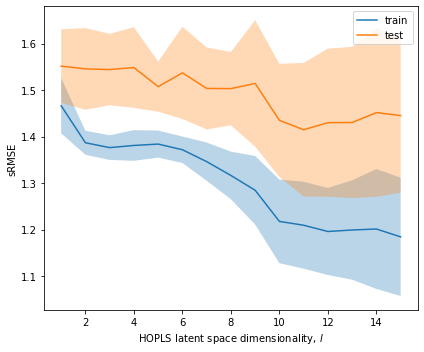

11 components with nRMSE = 1.4146699813977759 +- 0.05377499409412363


In [46]:
rmse = []
for R in tqdm(range(1,16)):
    tr = []
    te = []
    for j in range(10):
        rmse_te, rmse_tr, _ = compute_rmse_hopls(X_tr_hb_arr_n[j],Y_tr_hb_arr_n[j],X_te_hb_arr_n[j],Y_te_hb_arr_n[j], (2,3,3,1), (3,1), hankelization=[H_b_arr[j][-2],H_b_arr[j][-1]], R_max=R,train=True)
        tr.append(rmse_tr)
        te.append(rmse_te)
    rmse.append((R, tr, te))

x = [r[0] for r in rmse]
y1_mean = np.array([np.mean(r[1]) for r in rmse])
y2_mean = np.array([np.mean(r[2]) for r in rmse])
y1_std = np.array([np.std(r[1]) for r in rmse])
y2_std = np.array([np.std(r[2]) for r in rmse])
plt.figure(figsize=(6, 5))

plt.plot(x, y1_mean, label='train')
plt.fill_between(x, y1_mean - y1_std, y1_mean + y1_std, alpha=0.3)

plt.plot(x, y2_mean, label='test')
plt.fill_between(x, y2_mean - y2_std, y2_mean + y2_std, alpha=0.3)
plt.ylabel(r'sRMSE')
plt.xlabel(r'HOPLS latent space dimensionality, $l$')

plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

print(np.argmin(np.array(y2_mean))+1,'components with nRMSE =', min(y2_mean), '+-', min(y2_std))


### MPCA

In [59]:
U_x = scipy.io.loadmat('MPCA/32_X_hb.mat')['ans']
U_y = scipy.io.loadmat('MPCA/32_Y_hb.mat')['ans']
print('X',[U_x[i,0].shape[0] for i in range(U_x.shape[0])])
print('Y',[U_y[i,0].shape[0] for i in range(U_y.shape[0])])

X [10, 1, 7, 2]
Y [8, 3]


In [19]:
MSE_test = dict(np.load('experiments/ECoG32_hb_hb_mpca.npz'))
print('Time. Size of core tensor is', min(MSE_test, key=MSE_test.get), 'nRMSE =', MSE_test[min(MSE_test, key=MSE_test.get)])

Time. Size of core tensor is (3, 1, 7, 2) nRMSE = 1.9446141851604182


In [60]:
RMSE_MPCA = []
for j in tqdm(range(10)):
    RMSE_MPCA.append(compute_rmse_mpca(X_tr_hb_arr_n[j],Y_tr_hb_arr_n[j],X_te_hb_arr_n[j],Y_te_hb_arr_n[j], [3,1,7,2], U_x, U_y, H_b_arr[j][-1]))  
print(np.array(RMSE_MPCA).mean(), '+-',  np.array(RMSE_MPCA).std())

100%|██████████| 10/10 [46:09<00:00, 276.94s/it]

1.9126800895003537 +- 0.07163892088182873


### Autoencoder

In [10]:
MSE_test = dict(np.load('experiments/ECoG32_hb.npz'))
print('The best size of core tensor is', min(MSE_test, key=MSE_test.get))

The best size of core tensor is 3,1,3,2


In [ ]:
lr = 0.01
batch_size = 512
loss_fn = my_loss(3)
epochs = 35
step_size = 100

RMSE_AE = []
for j in range(10):

    fr, ch, y_sh = X_test_arr_n[j].shape[1], X_test_arr_n[j].shape[2], Y_test_arr_n[j].shape[1]
    ks1 = [fr,32,16,8,1]
    ks2 = [ch-1,16,8,3]

    model = AutoEncoder_tensor(5, [ks1, ks2, [2,3,2]], [10,3], y_sh*10, indexing=True).to(device)
    model = train(model, X_tr_hb_arr_t[j],Y_tr_hb_arr_t[j],X_te_hb_arr_t[j],Y_te_hb_arr_t[j], lr, step_size, batch_size, epochs, loss_fn, True);

    X_train_lower = model.encode(X_tr_hb_arr_t[j]).cpu().detach().numpy()
    X_test_lower = model.encode(X_te_hb_arr_t[j]).cpu().detach().numpy()

    RMSE_dict = {}
    for rank1 in range(1,X_train_lower.shape[1]+1,1):   
        for rank2 in range(1,X_train_lower.shape[2]+1,1):
            for rank3 in range(1,X_train_lower.shape[3]+1,1):
                for rank4 in range(1,X_train_lower.shape[4]+1,1):
                    RMSE_dict[f'{rank1},{rank2},{rank3},{rank4}'] = tensor_regression(X_train_lower, Y_tr_hb_arr_n[j], X_test_lower, Y_te_hb_arr_n[j], [rank1,rank2,rank3,rank4], H_b_arr[j][-1])

    RMSE_AE.append( RMSE_dict[min(RMSE_dict, key=RMSE_dict.get)])

In [34]:
print(np.array(RMSE_AE).mean(), '+-',  np.array(RMSE_AE).std())

1.119925596126198 +- 0.0317191715981571


In [36]:
fr, ch, y_sh = X_test_arr_n[j].shape[1], X_test_arr_n[j].shape[2], Y_test_arr_n[j].shape[1]
ks1 = [fr,32,16,8,1]
ks2 = [ch-1,16,8,3]

model = AutoEncoder_tensor(5, [ks1, ks2, [2,3,2]], [10,3], y_sh*10, indexing=True).to(device)
print('Number of parameters:', sum(p.numel() for p in model.parameters()))

Number of parameters: 6390


In [65]:
Y_random = []
Y_zeros = []
for j in range(10):
    Y_zeros.append(np.zeros(Y_test_arr_n[j].shape))
    Y_random.append(np.random.normal(0,1,Y_test_arr_n[j].shape))

In [66]:
rmse_random = []
rmse_zeros = []
for j in range(10):
    rmse_random.append(metric_nmse_(Y_random[j],Y_test_arr_n[j]))
    rmse_zeros.append(metric_nmse_(Y_zeros[j],Y_test_arr_n[j]))

In [67]:
print(np.array(rmse_zeros).mean(), '+-', np.array(rmse_zeros).std())
print(np.array(rmse_random).mean(), '+-', np.array(rmse_random).std())

2.514091651550246 +- 0.08765840931168181
3.786239614653129 +- 0.16058007215585735


In [18]:
plt.rcParams.update({
    # Use LaTeX default serif font-family.
    # https://matplotlib.org/stable/tutorials/text/usetex.html#sphx-glr-tutorials-text-usetex-py
     "font.family": "serif",
     # Use specific cursive fonts.
     "font.cursive": ["Comic Neue", "Comic Sans MS"],
 })
plt.style.use('seaborn-white')

plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['figure.titlesize'] = 20
%matplotlib inline
%config InlineBackend.figure_format='retina'

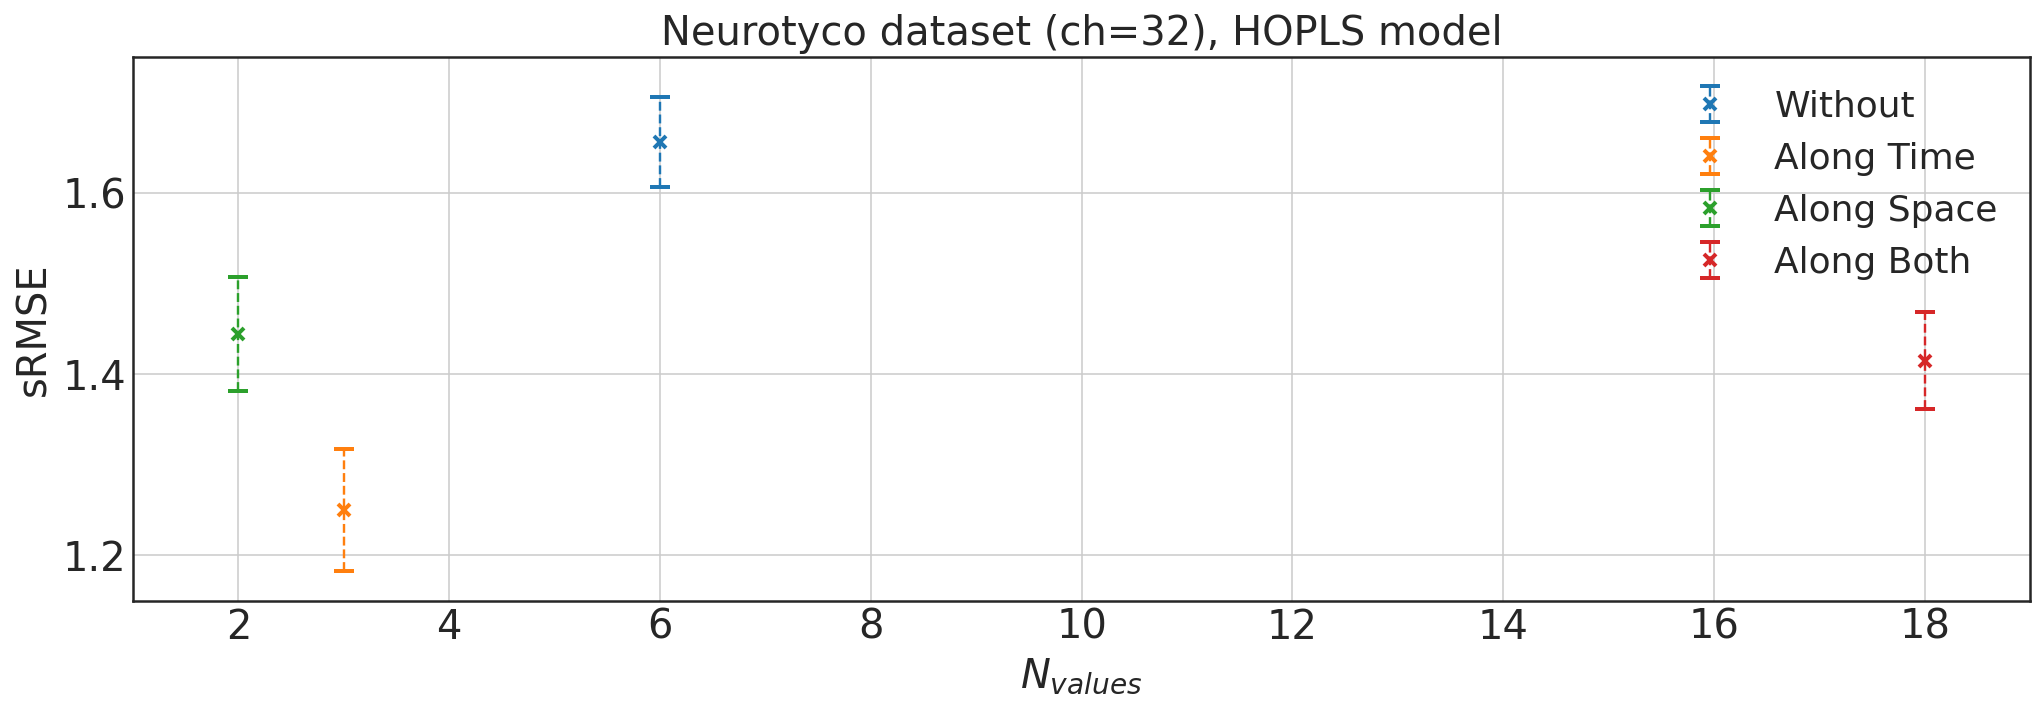

In [25]:
fig = plt.figure(figsize=(17,5))
labels = ['Without', 'Along Time', 'Along Space', 'Along Both']
xs = np.array([6, 3, 2, 18])
ys = np.array([1.656, 1.250, 1.444, 1.415])
es = np.array([0.05, 0.067, 0.063, 0.054])

for x, y, e, c in zip(xs,ys,es,range(4)):
    eb1=plt.errorbar(x, y, e, linestyle='None', marker='x', capsize=5, elinewidth=1.2, markeredgewidth=2, label=labels[c])#, ecolor=c)
    eb1[-1][0].set_linestyle('--') 
# for i,(xitem,yitem) in enumerate(np.nditer([x,y])):
#     plt.annotate(labels[i], (xitem,yitem), textcoords="offset points",xytext=((-1)**i*35,5),ha="center")
plt.ylim(1.15,1.75)
plt.xlim(1,19)
plt.ylabel('sRMSE', fontsize=20)
plt.xlabel(r'$N_{values}$', fontsize=20)
plt.grid(True)
plt.legend()
plt.savefig('ECoG32_HOPLS.jpg', dpi=300)
plt.title('Neurotyco dataset (ch=32), HOPLS model')
plt.show()

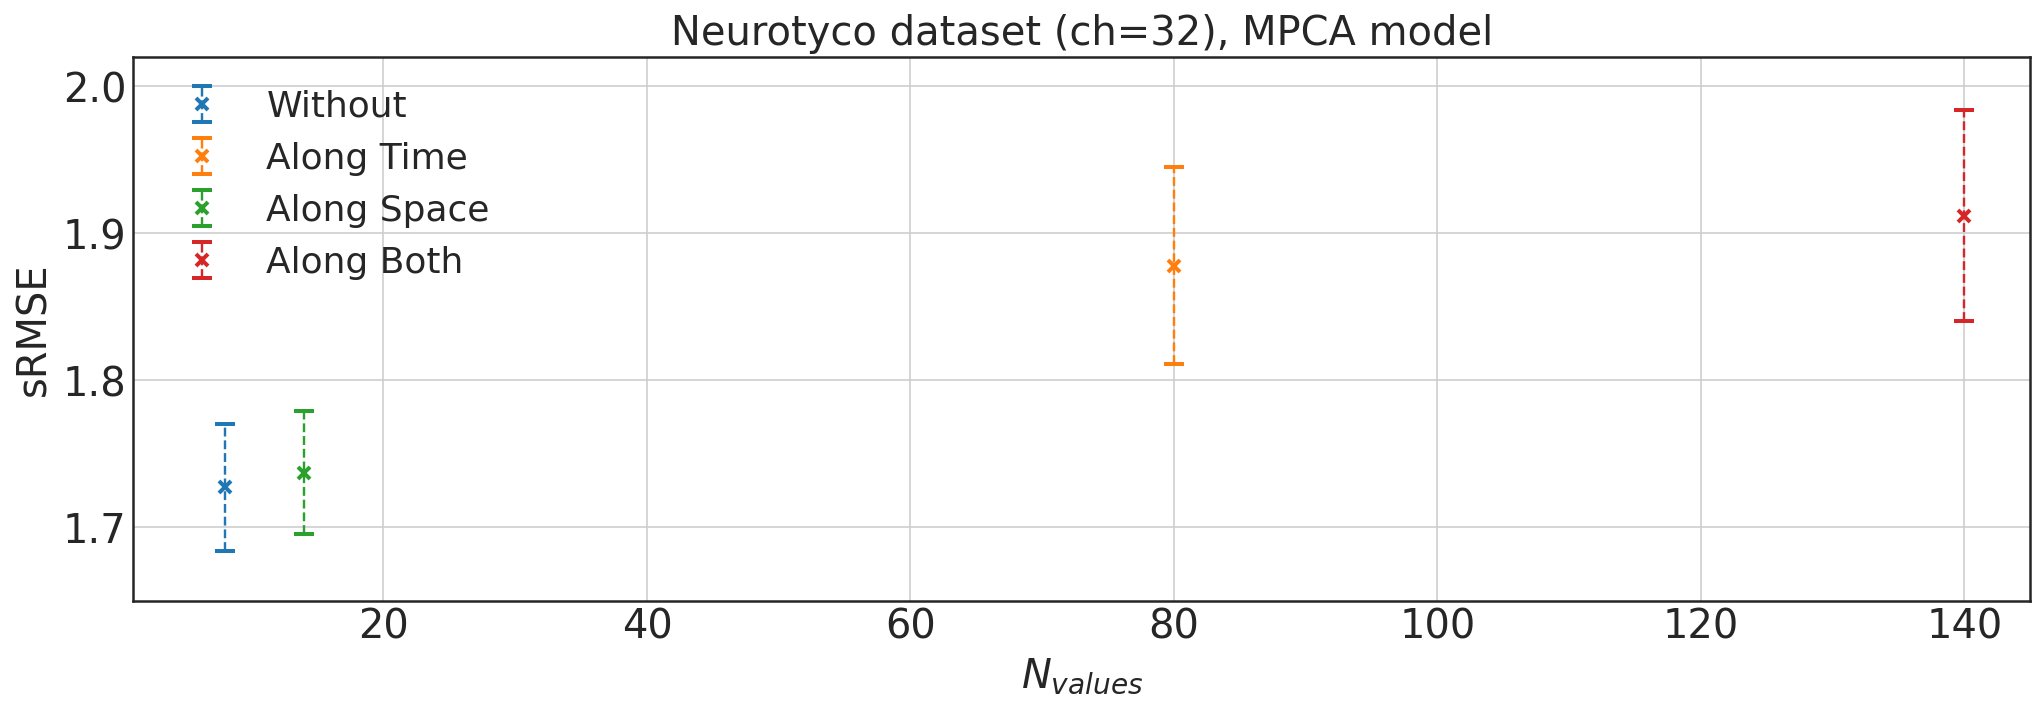

In [26]:
fig = plt.figure(figsize=(17,5))
labels = ['Without', 'Along Time', 'Along Space', 'Along Both']
xs = np.array([8, 80, 14, 140])
ys = np.array([1.727, 1.878, 1.737, 1.912])
es = np.array([0.043, 0.067, 0.042, 0.072])

for x, y, e, c in zip(xs,ys,es,range(4)):
    eb1=plt.errorbar(x, y, e, linestyle='None', marker='x', capsize=5, elinewidth=1.2, markeredgewidth=2, label=labels[c])#, ecolor=c)
    eb1[-1][0].set_linestyle('--')  
# for i,(xitem,yitem) in enumerate(np.nditer([x,y])):
#     plt.annotate(labels[i], (xitem,yitem), textcoords="offset points",xytext=((-1)**i*30,(-1)**(i//2)*15),ha="center")
plt.ylim(1.65,2.02)
plt.xlim(1,145)
plt.ylabel('sRMSE', fontsize=20)
plt.xlabel(r'$N_{values}$', fontsize=20)
plt.grid(True)
plt.legend()
plt.savefig('ECoG32_MPCA.jpg', dpi=300)
plt.title('Neurotyco dataset (ch=32), MPCA model')
plt.show()

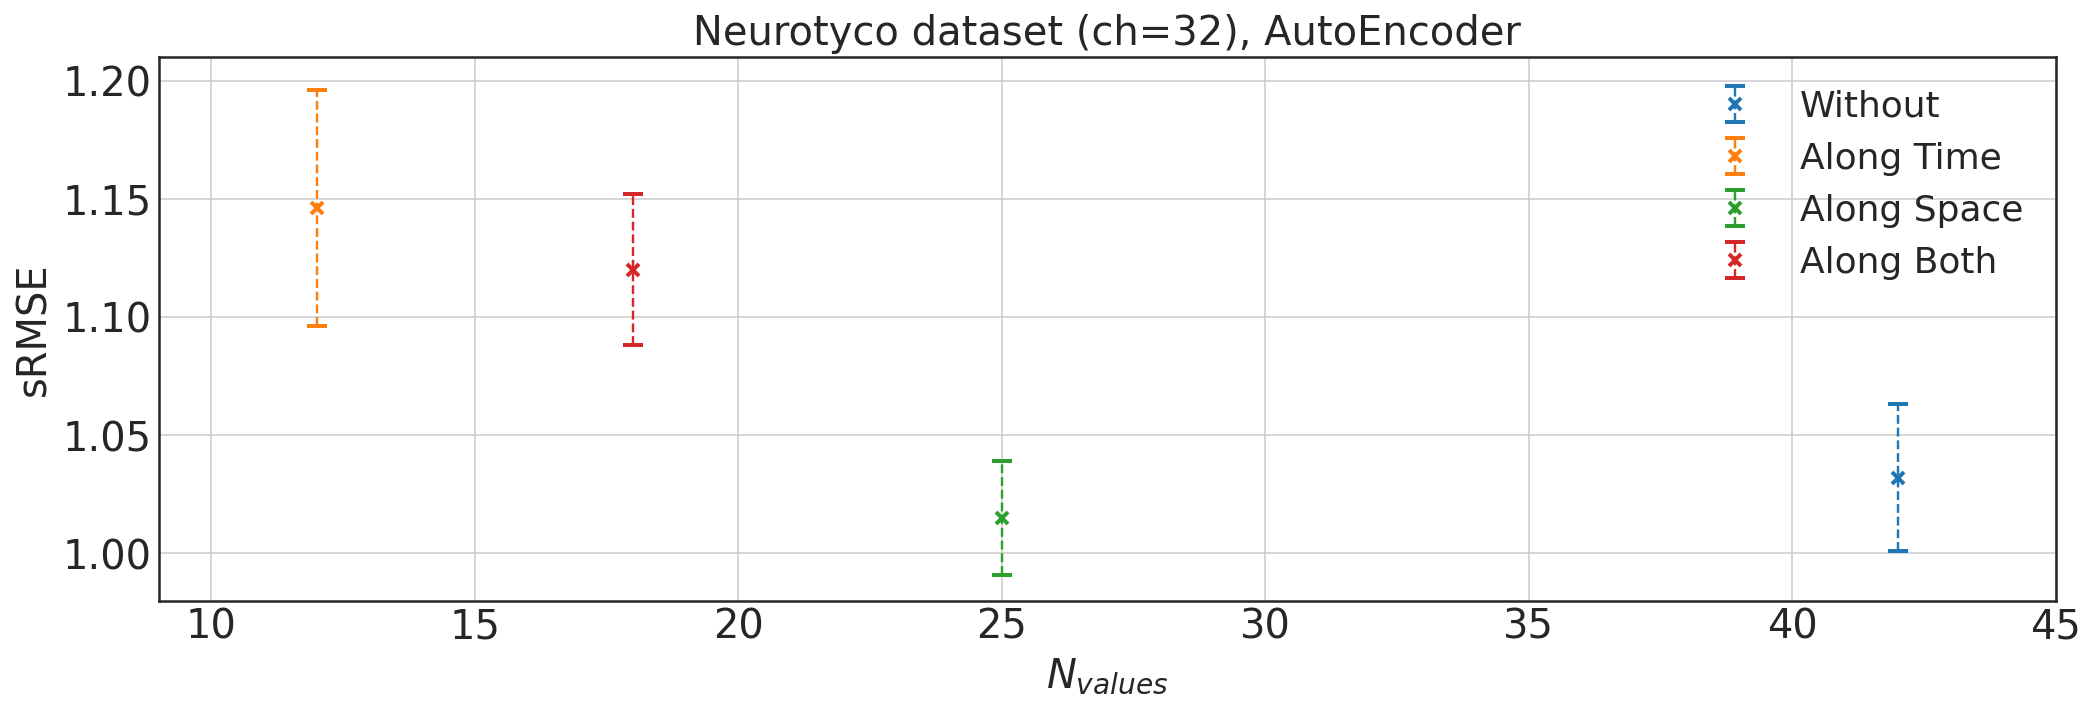

In [40]:
fig = plt.figure(figsize=(17,5))
labels = ['Without', 'Along Time', 'Along Space', 'Along Both']
xs = np.array([42, 12, 25, 18])
ys = np.array([1.032, 1.146, 1.015, 1.120])
es = np.array([0.031, 0.050, 0.024, 0.032])

for x, y, e, c in zip(xs,ys,es,range(4)):
    eb1=plt.errorbar(x, y, e, linestyle='None', marker='x', capsize=5, elinewidth=1.2, markeredgewidth=2, label=labels[c])#, ecolor=c)
    eb1[-1][0].set_linestyle('--')  
# for i,(xitem,yitem) in enumerate(np.nditer([x,y])):
#     plt.annotate(labels[i], (xitem,yitem), textcoords="offset points",xytext=((-1)**i*30,(-1)**(i//2)*15),ha="center")
plt.ylim(0.98,1.21)
plt.xlim(9,45)
plt.ylabel('sRMSE', fontsize=20)
plt.xlabel(r'$N_{values}$', fontsize=20)
plt.grid(True)
plt.legend()
plt.savefig('ECoG32_AE.jpg', dpi=300)
plt.title('Neurotyco dataset (ch=32), AutoEncoder')
plt.show()